In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

<h1> Machine Learning Models </h1>

<h2> Reading data from file and storing into sql table </h2>

In [4]:
df= pd.read_csv('D:/AAIC/quora CS/final_features.csv', nrows=100000)

In [5]:

df.head(2)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040


In [6]:
# remove the first row 
df.drop(df.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [7]:
y_true

1        0
2        0
3        0
4        0
5        1
        ..
99995    0
99996    0
99997    1
99998    0
99999    0
Name: is_duplicate, Length: 99999, dtype: int64

<h2>  Converting strings to numerics </h2>

In [8]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(df.columns)
for i in cols:
    df[i] = df[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [9]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> Random train test split( 70:30) </h2>

In [10]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (69999, 794)
Number of data points in test data : (30000, 794)


In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274518207402963 Class 1:  0.3725481792597037
---------- Distribution of output variable in test data ----------
Class 0:  0.6274666666666666 Class 1:  0.3725333333333333


In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8874522812412007


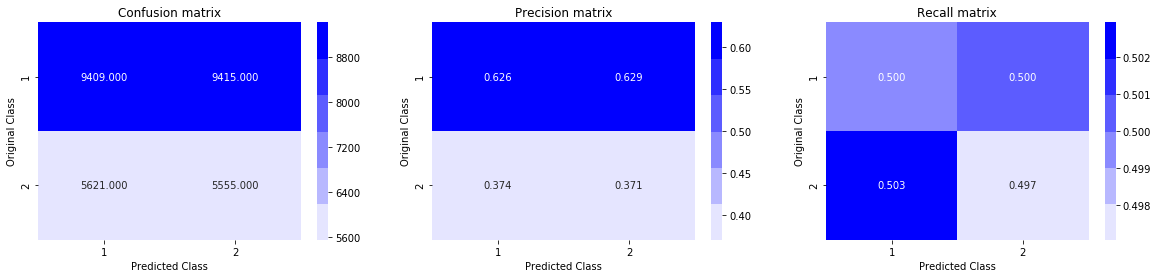

In [13]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2>  Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5161268472633854
For values of alpha =  0.0001 The log loss is: 0.45280634271020836
For values of alpha =  0.001 The log loss is: 0.44106772500587443
For values of alpha =  0.01 The log loss is: 0.4573443181157958
For values of alpha =  0.1 The log loss is: 0.4491898899231689
For values of alpha =  1 The log loss is: 0.47428049164436825
For values of alpha =  10 The log loss is: 0.5164155077442683


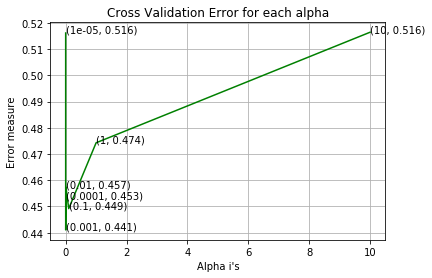

For values of best alpha =  0.001 The train log loss is: 0.4335848712664139
For values of best alpha =  0.001 The test log loss is: 0.44106772500587443
Total number of data points : 30000


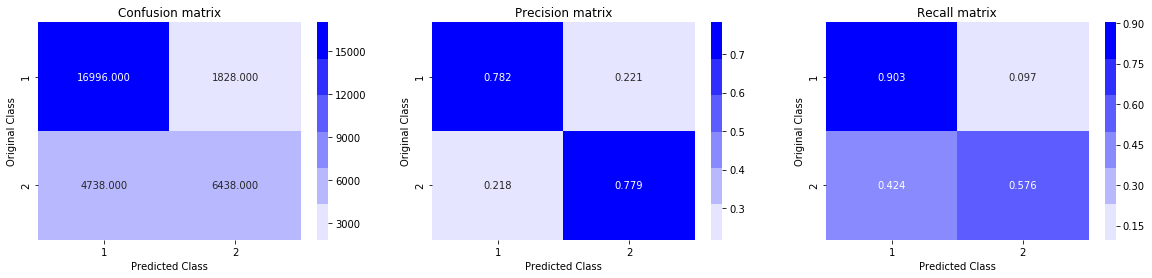

In [14]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>  Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6602902123522941


C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.0001 The log loss is: 0.6602902123522941


C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

For values of alpha =  0.001 The log loss is: 0.6602902123522941


C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

For values of alpha =  0.01 The log loss is: 0.5562693057253287


C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

For values of alpha =  0.1 The log loss is: 0.5852788858378706


C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

For values of alpha =  1 The log loss is: 0.6405840816263493


C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

For values of alpha =  10 The log loss is: 0.6602902123522941


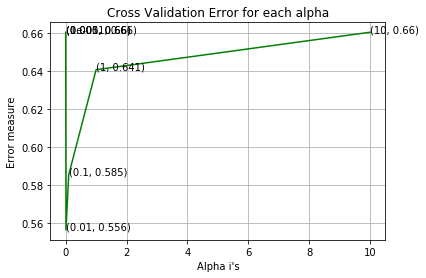

C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mihir\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

For values of best alpha =  0.01 The train log loss is: 0.5530580212605491
For values of best alpha =  0.01 The test log loss is: 0.5562693057253287
Total number of data points : 30000


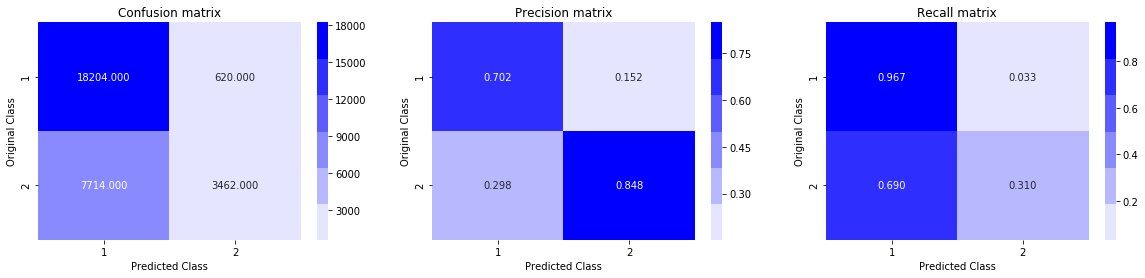

In [15]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [16]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68492	valid-logloss:0.68482
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61611	valid-logloss:0.61560
[20]	train-logloss:0.56573	valid-logloss:0.56496
[30]	train-logloss:0.52798	valid-logloss:0.52708
[40]	train-logloss:0.49858	valid-logloss:0.49776
[50]	train-logloss:0.47571	valid-logloss:0.47506
[60]	train-logloss:0.45738	valid-logloss:0.45685
[70]	train-logloss:0.44294	valid-logloss:0.44256
[80]	train-logloss:0.43095	valid-logloss:0.43064
[90]	train-logloss:0.42125	valid-logloss:0.42108
[100]	train-logloss:0.41306	valid-logloss:0.41302
[110]	train-logloss:0.40619	valid-logloss:0.40634
[120]	train-logloss:0.40043	valid-logloss:0.40075
[130]	train-logloss:0.39552	valid-logloss:0.39598
[140]	train-logloss:0.39096	valid-logloss:0.39162
[150]	train-logloss:0.38731	valid-logloss:0.38818
[160]	train-logloss:0.38416	valid-logloss:0.38522
[170]	trai

Total number of data points : 30000


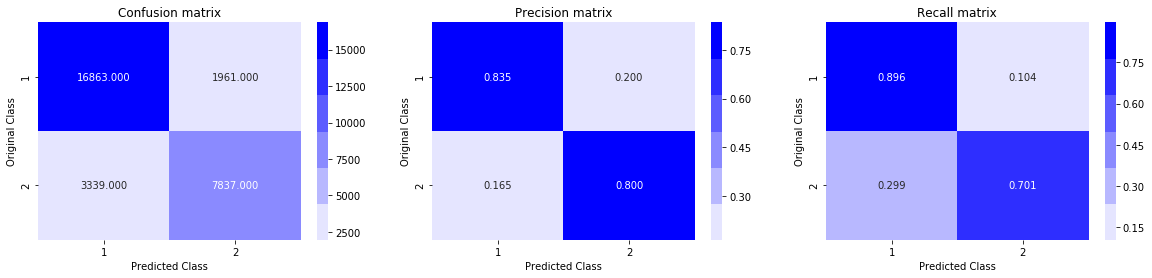

In [17]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Performing hyperparameter tuning  of XgBoost models using RandomsearchCV with vectorizer as TF-IDF W2V  to reduce the log-loss.


In [14]:
dfxg=pd.read_csv('D:/AAIC-PROJS/QUORA/Quora-20200911T114809Z-001/Quora/nlp_features_train.csv',encoding='latin-1', nrows=100000)

In [15]:
y = dfxg['is_duplicate'].values
X = dfxg.drop(['is_duplicate'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train)

X_train['question1'] = X_train['question1'].apply(lambda x: str(x))
X_train['question2'] = X_train['question2'].apply(lambda x: str(x))

X_test['question1'] = X_test['question1'].apply(lambda x: str(x))
X_test['question2'] = X_test['question2'].apply(lambda x: str(x))

X_cv['question1'] = X_cv['question1'].apply(lambda x: str(x))
X_cv['question2'] = X_cv['question2'].apply(lambda x: str(x))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf.get_feature_names(), tfidf.idf_))


# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# # merge texts
# questions = list(X_test['question1']) + list(X_test['question2'])

# # tfidf = TfidfVectorizer(lowercase=False, )
# tfidf.fit_transform(questions)

# # dict key:word and value:tf-idf score
# word2tfidf_test = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

# questions = list(X_cv['question1']) + list(X_cv['question2'])

# # tfidf = TfidfVectorizer(lowercase=False, )
# tfidf.fit_transform(questions)

# # dict key:word and value:tf-idf score
# word2tfidf_cv = dict(zip(tfidf.get_feature_names(), tfidf.idf_))



In [17]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')


100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [04:46<00:00, 170.84it/s]


In [18]:

vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)



100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [04:42<00:00, 173.37it/s]


In [19]:
dftr_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
dftr_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [21]:
train_df=pd.concat([dftr_q1, dftr_q2], axis=1)


In [22]:
train_df=pd.concat([X_train,train_df],axis=1)


In [23]:
df_train=train_df.drop(columns=['id','qid1','qid2','question1','question2','q2_feats_m','q1_feats_m'])

In [24]:
df_train.shape

(49000, 207)

In [26]:


# en_vectors_web_sm, which includes over 1 million unique vectors.
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)


# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')



vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)



dfte_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
dfte_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:54<00:00, 171.76it/s]


In [27]:
test_df=pd.concat([dfte_q1, dfte_q2], axis=1)


test_df=pd.concat([X_test,test_df],axis=1)


df_test=test_df.drop(columns=['id','qid1','qid2','question1','question2','q2_feats_m','q1_feats_m'])

In [32]:
y_train.shape

(49000,)

In [29]:


# en_vectors_web_sm, which includes over 1 million unique vectors.
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_cv['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_cv['q1_feats_m'] = list(vecs1)


# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')



vecs2 = []
for qu2 in tqdm(list(X_cv['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_cv['q2_feats_m'] = list(vecs2)



dfcv_q1 = pd.DataFrame(X_cv.q1_feats_m.values.tolist(), index= X_cv.index)
dfcv_q2 = pd.DataFrame(X_cv.q2_feats_m.values.tolist(), index= X_cv.index)

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [02:06<00:00, 166.46it/s]


In [30]:
cv_df=pd.concat([dfcv_q1, dfcv_q2], axis=1)


cv_df=pd.concat([X_cv,cv_df],axis=1)


df_cv=cv_df.drop(columns=['id','qid1','qid2','question1','question2','q2_feats_m','q1_feats_m'])

In [52]:
df_train.shape


(49000, 207)

In [31]:
df_train.to_csv('train_dfnew.csv')

In [32]:
df_cv.to_csv('cv_df.csv')

In [33]:
df_test.to_csv('test_df.csv')


In [34]:
X_train=pd.read_csv('train_dfnew.csv')
X_test=pd.read_csv('test_df.csv')
X_cv=pd.read_csv('cv_df.csv')



In [35]:
y_test.shape


(30000,)

In [36]:
X_train=X_train.drop(['Unnamed: 0'],axis=1)

In [37]:
X_test=X_test.drop(['Unnamed: 0'],axis=1)
X_cv=X_cv.drop(['Unnamed: 0'],axis=1)

In [38]:
X_train.shape

(49000, 207)

In [39]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# this code is taken fromhttps://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
clf = xgb.XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [5, 10, 15, 20],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100],
        'objective':['binary:logistic'],
        'eval_metric': ['logloss'],
        'eta':[0.01,.02,.04,.05]
        }

fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X_cv, y_cv)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            scoring='neg_log_loss', refit=False, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] subsample=0.7, silent=False, reg_lambda=50.0, objective=binary:logistic, n_estimators=100, min_child_weight=5.0, max_depth=5, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.05, colsample_bytree=0.6, colsample_bylevel=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, silent=False, reg_lambda=50.0, objective=binary:logistic, n_estimators=100, min_child_weight=5.0, max_depth=5, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.05, colsample_bytree=0.6, colsample_bylevel=0.4, total=   7.2s
[CV] subsample=0.7, silent=False, reg_lambda=50.0, objective=binary:logistic, n_estimators=100, min_child_weight=5.0, max_depth=5, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.05, colsample_bytree=0.6, colsample_bylevel=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV]  subsample=0.7, silent=False, reg_lambda=50.0, objective=binary:logistic, n_estimators=100, min_child_weight=5.0, max_depth=5, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.05, colsample_bytree=0.6, colsample_bylevel=0.4, total=   4.2s
[CV] subsample=0.6, silent=False, reg_lambda=1.0, objective=binary:logistic, n_estimators=100, min_child_weight=1.0, max_depth=20, learning_rate=0.2, gamma=0.5, eval_metric=logloss, eta=0.01, colsample_bytree=0.6, colsample_bylevel=0.6 
[CV]  subsample=0.6, silent=False, reg_lambda=1.0, objective=binary:logistic, n_estimators=100, min_child_weight=1.0, max_depth=20, learning_rate=0.2, gamma=0.5, eval_metric=logloss, eta=0.01, colsample_bytree=0.6, colsample_bylevel=0.6, total=  12.3s
[CV] subsample=0.6, silent=False, reg_lambda=1.0, objective=binary:logistic, n_estimators=100, min_child_weight=1.0, max_depth=20, learning_rate=0.2, gamma=0.5, eval_metric=logloss, eta=0.01, colsample_bytree=0.6, colsample_bylevel=0.6 
[CV]  subsample=0.6, 

[CV]  subsample=0.8, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=7.0, max_depth=20, learning_rate=0.2, gamma=0, eval_metric=logloss, eta=0.02, colsample_bytree=0.7, colsample_bylevel=0.4, total=  13.3s
[CV] subsample=0.8, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=7.0, max_depth=20, learning_rate=0.2, gamma=0, eval_metric=logloss, eta=0.02, colsample_bytree=0.7, colsample_bylevel=0.4 
[CV]  subsample=0.8, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=7.0, max_depth=20, learning_rate=0.2, gamma=0, eval_metric=logloss, eta=0.02, colsample_bytree=0.7, colsample_bylevel=0.4, total=  12.8s
[CV] subsample=0.7, silent=False, reg_lambda=50.0, objective=binary:logistic, n_estimators=100, min_child_weight=0.5, max_depth=10, learning_rate=0.2, gamma=0.25, eval_metric=logloss, eta=0.01, colsample_bytree=0.7, colsample_bylevel=0.7 
[CV]  subsample=0.7,

[CV]  subsample=1.0, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=1.0, max_depth=5, learning_rate=0.1, gamma=0.5, eval_metric=logloss, eta=0.05, colsample_bytree=0.5, colsample_bylevel=0.8, total=   7.6s
[CV] subsample=0.6, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=7.0, max_depth=20, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.04, colsample_bytree=1.0, colsample_bylevel=0.4 
[CV]  subsample=0.6, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=7.0, max_depth=20, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.04, colsample_bytree=1.0, colsample_bylevel=0.4, total=  13.7s
[CV] subsample=0.6, silent=False, reg_lambda=100.0, objective=binary:logistic, n_estimators=100, min_child_weight=7.0, max_depth=20, learning_rate=0.01, gamma=1.0, eval_metric=logloss, eta=0.04, colsample_bytree=1.0, colsample_bylevel=0.4 
[CV]  subsam

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  8.8min finished


In [76]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 5
params['n_estimators']= 100
params['gamma'] = 0.5
params['colsample_bylevel'] = 0.8
params['colsample_bytree'] = 0.5
params['learning_rate'] = 0.2
params['silent'] = False
params['subsample'] = 1
params['reg_lambda'] = 100.0
params['min_child_weight'] = 1.0


d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

[01:42:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64096	valid-logloss:0.64084
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.49193	valid-logloss:0.49128
[20]	train-logloss:0.46704	valid-logloss:0.46804
[30]	train-logloss:0.45510	valid-logloss:0.45750
[40]	train-logloss:0.44673	valid-logloss:0.45045
[50]	train-logloss:0.44097	valid-logloss:0.44580
[60]	train-logloss:0.43550	valid-logloss:0.44150
[70]	train-logloss:0.43125	valid-logloss:0.43798
[80]	train-logloss:0.42795	valid-logloss:0.43560
[90]	train-

In [77]:
predicted_values=[]
for i in predict_y:
    if i<0.5:
        predicted_values.append(0)
    else:
        predicted_values.append(1)
        

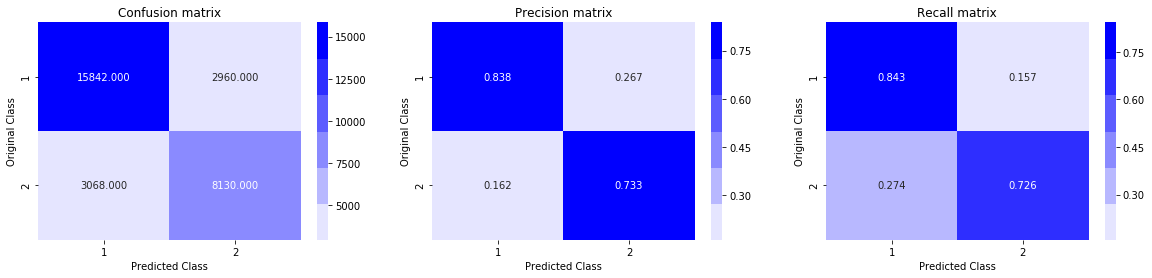

In [78]:
plot_confusion_matrix(y_test, predicted_values)

From the confusion matrix, it can be observed that the recall and precision has improved as compared to the confusion matrix of 
the linear SVM and logistic regression. 

# Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.


In [65]:
df=pd.read_csv('D:/AAIC/Quora-20200416T122507Z-001/Quora/nlp_features_train.csv',encoding='latin-1', nrows=100000)

In [66]:
y = df['is_duplicate'].values
X = df.drop(['is_duplicate'], axis=1)

In [67]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [68]:
X_train['question1'] = X_train['question1'].apply(lambda x: str(x))
X_train['question2'] = X_train['question2'].apply(lambda x: str(x))

X_test['question1'] = X_test['question1'].apply(lambda x: str(x))
X_test['question2'] = X_test['question2'].apply(lambda x: str(x))

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
qtrain = list(X_train['question1']) + list(X_train['question2'])
vecttfidf_question = TfidfVectorizer(lowercase=False,min_df=10)
vecttfidf_question.fit(qtrain)

q1tfidf_tr = vecttfidf_question.transform(X_train['question1'])
q2tfidf_tr = vecttfidf_question.transform(X_train['question2'])
print("Shape of matrix ",q1tfidf_tr.shape)
print("Shape of matrix ",q2tfidf_tr.shape)

Shape of matrix  (70000, 8036)
Shape of matrix  (70000, 8036)


In [70]:
q1tfidf_te = vecttfidf_question.transform(X_test['question1'])
q2tfidf_te = vecttfidf_question.transform(X_test['question2'])
print("Shape of matrix ",q1tfidf_te.shape)
print("Shape of matrix ",q2tfidf_te.shape)

Shape of matrix  (30000, 8036)
Shape of matrix  (30000, 8036)


In [71]:
X_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [72]:
X_train = X_train.drop(['id','question1','question2','qid1','qid2'],axis=1)
X_test = X_test.drop(['id','question1','question2','qid1','qid2'],axis=1)

In [73]:
X_train = hstack((X_train,q1tfidf_tr,q2tfidf_tr))
X_test = hstack((X_test,q1tfidf_te,q2tfidf_te))


For values of alpha =  1e-05 The log loss is: 0.45749557657055756
For values of alpha =  0.0001 The log loss is: 0.4530156159402627
For values of alpha =  0.001 The log loss is: 0.490313554873835
For values of alpha =  0.01 The log loss is: 0.5460317227742179
For values of alpha =  0.1 The log loss is: 0.5831182889065538
For values of alpha =  1 The log loss is: 0.5954884896413657
For values of alpha =  10 The log loss is: 0.6066151574812287


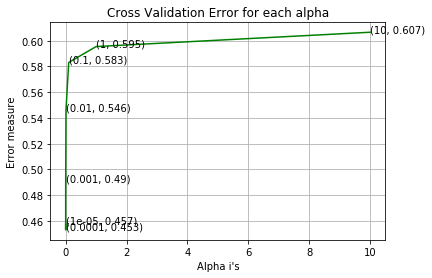

For values of best alpha =  0.0001 The train log loss is: 0.44379177469898634
For values of best alpha =  0.0001 The test log loss is: 0.4530156159402627
Total number of data points : 30000


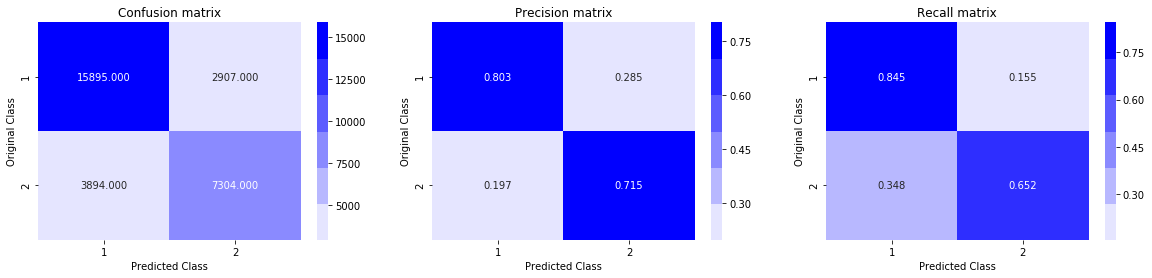

In [74]:
# Logistic regression
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.5043456020149342
For values of alpha =  0.0001 The log loss is: 0.5218932749168892
For values of alpha =  0.001 The log loss is: 0.5447474359197522
For values of alpha =  0.01 The log loss is: 0.5615214689257189
For values of alpha =  0.1 The log loss is: 0.604701347756123
For values of alpha =  1 The log loss is: 0.6588368762810207
For values of alpha =  10 The log loss is: 0.660673698569075


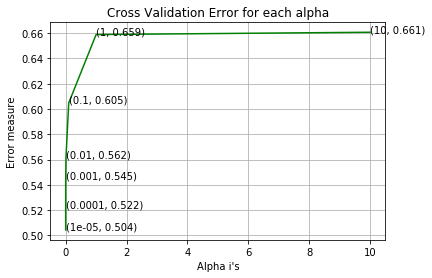

For values of best alpha =  1e-05 The train log loss is: 0.4958473132677425
For values of best alpha =  1e-05 The test log loss is: 0.5043456020149342
Total number of data points : 30000


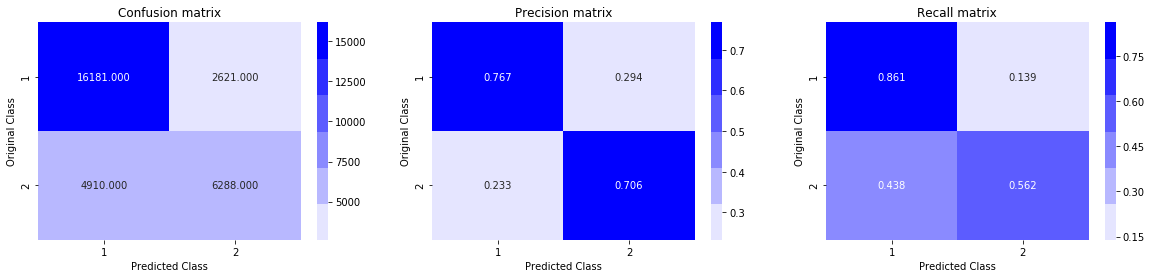

In [80]:
# Linear SVM

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [81]:
from prettytable import PrettyTable
table = PrettyTable() 
table.field_names = ["Vectorizer", "Model","Test logloss"] 
table.add_row(["TFIDF-W2V", "XG Boost" ,0.4051])
table.add_row(["TFIDF", "Logistic Regression",0.4530])
table.add_row(["TFIDF", "Linear SVM",0.5043]) 

print(table)

+------------+---------------------+--------------+
| Vectorizer |        Model        | Test logloss |
+------------+---------------------+--------------+
| TFIDF-W2V  |       XG Boost      |    0.4051    |
|   TFIDF    | Logistic Regression |    0.453     |
|   TFIDF    |      Linear SVM     |    0.5043    |
+------------+---------------------+--------------+


## Summary:

From the confusion matrices, it can be inferred that XG Boost works best for the given dataset.